<a href="https://colab.research.google.com/github/clami66/AF_unmasked/blob/notebook/notebooks/AF_unmasked.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AF_unmasked: a simplified notebook

<img src="https://github.com/clami66/AF_unmasked/raw/main/fig/header.png" height="200">

This notebook allows to run AF_unmasked on multimeric sequences and templates of your choice. Not all features implemented on the command line version of AF_unmasked are currently available on the notebook, but more will come later.

This version of AF_unmasked relies on MMseqs2 alignments, run by the [ColabFold](https://github.com/sokrypton/ColabFold) MSA server. Some of the code on this notebook is also based or taken from the ColabFold notebook.

# 1: setting up the job

In [1]:
# Imports
import os
from sys import version_info, path

import pickle
import shutil
import importlib_metadata
from pathlib import Path
from string import ascii_uppercase, ascii_lowercase
ascii_upperlower = ascii_uppercase + ascii_lowercase
from scipy.special import softmax
import matplotlib.pyplot as plt

import ipywidgets as widgets
from ipyfilechooser import FileChooser

from alphafold.data.prepare_templates import *
from alphafold.data.mmseqs_2_uniprot import *
from Bio import Align, SeqIO, AlignIO
from Bio.PDB.mmcifio import MMCIFIO

from colabfold.batch import get_msa_and_templates, msa_to_str
from colabfold.utils import DEFAULT_API_SERVER, get_commit
from colabfold.download import download_alphafold_params

from run_alphafold import predict_structure
from alphafold.data import pipeline, pipeline_multimer

from alphafold.data.tools import hmmsearch, jackhmmer
from alphafold.data import templates

from alphafold.model import model, data, config

Clean up outputs from previous experiments:

In [22]:
!rm -r AF_models/H1142/template_data
!rm AF_models/H1142/msas/*/*
!rm AF_models/H1142/*.pdb
!rm AF_models/H1142/*.pkl

/home/ubuntu/miniconda3/envs/AF_unmasked/lib/python3.9/pty.py:85: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


rm: cannot remove 'AF_models/H1142/*.pkl': No such file or directory


Select a .fasta input and a .pdb/.cif template:

In [3]:
fasta_chooser = FileChooser('/home/ubuntu/software/AF_unmasked/examples')
fasta_chooser.title = '<b>Select .fasta file</b>'
display(fasta_chooser)

pdb_chooser = FileChooser('/home/ubuntu/software/AF_unmasked/examples')
pdb_chooser.title = '<b>Select .pdb file</b>'
display(pdb_chooser)

FileChooser(path='/home/ubuntu/software/AF_unmasked/examples', filename='', title='<b>Select .fasta file</b>',…

FileChooser(path='/home/ubuntu/software/AF_unmasked/examples', filename='', title='<b>Select .pdb file</b>', s…

Load the target and template data, you will see the sequences from the fasta and the PDB below:

In [23]:
fasta = fasta_chooser.value
pdb = pdb_chooser.value

jobname = os.path.basename(fasta).split(".")[0]
out_dir = Path(f"AF_models/{jobname}")
out_dir.mkdir(parents=True, exist_ok=True)
targets = out_dir.joinpath(f"{jobname}.fasta")

_ = shutil.copyfile(fasta, targets)

if not is_fasta(targets):
  raise ValueError("""The input does not appear to be in fasta format
  Example of fasta format input:
  > H1142_A
  GLEKDFLPLYFGWFLTK...
  > H1142_B
  EVQLEESGGGLVQAGGS...
  """)

with open(targets, "r") as f:
  print("Fasta sequences:")
  print(f.read())
  print()

seq2chain = {}
chain_idx = 0
for record in SeqIO.parse(targets, "fasta"):
  if record.seq not in seq2chain:
    seq2chain[record.seq] = [ascii_upperlower[chain_idx]]
  else:
    seq2chain[record.seq].append(ascii_upperlower[chain_idx])
  chain_idx += 1

pdb = Path(pdb)

if pdb.name.endswith(".pdb"):
  template_format = "pdb"
elif pdb.name.endswith(".cif"):
  template_format = "cif"
else:
  raise ValueError("Template must be in .pdb or .cif format")

template = out_dir.joinpath(pdb.name)
_ = shutil.copyfile(pdb, template)
print(template)
# template data
template_model = load_PDB(str(template))
template_chains = [c.id for c in template_model]
remove_extra_chains(template_model, template_chains)
remove_hetatms(template_model)
template_sequences = [
        get_fastaseq(template_model, chain) for chain in template_chains
    ]

print("Template sequences:")
for seq, chain in zip(template_sequences, template_chains):
  print(f"Chain {chain}: {seq}")

# target data
target_chains, target_sequences, target_models = get_target_data(
            [str(targets)],
            chains=None,
            is_fasta=True,
        )
assert len(target_chains) <= len(
      template_chains
), f"Not enough chains in the template structure to cover all target chains. Partial templates are currently not supported on the colab version of AF_unmasked."

Fasta sequences:
>H1142,subunit1|_0
GLEKDFLPLYFGWFLTKKSSETLRKAGQVFLEELGNHKAFKKELRHFISGDEPKEKLELVSYFGKRPPGVLHCTTKFCDYKAAGAEEYAQQEVVKRSYGKAFKLSISALFVTPKTAGAQVVLTDQELQLWPSDLDKPSASEGLPPGSRAHVTLGCAADVQPVQTGLDLLDILQQVKGGSQGEAVGELPRGKLYSLGKGRWMLSLTKKMEVKAIFTGYYG
>H1142,subunit2|_0
EVQLEESGGGLVQAGGSLTLSCAASGFTFDDYAMGWYRQAPGKERVGVSCISRTDGYTYYLDSVKGRFTISTDHAKHTVYLQMNNLKPDDTGLYYCAADADPEYGSRCPDPYYGMDYWGKGILVTVSS


AF_models/H1142/H1142_interface_clip.pdb
Template sequences:
Chain A: GLEKDFLPLYFGWFLTKKSSETLRKAGQVFLEELGNHKAFKKELRHFISGDEPKEKLELVSYFGKRPPGVLHCTTKFCDYKAAGAEEYAQQEVVKRSYGKAFKLSISALFVTPKTAGAQVVLTDQELQLWPSDLDKPSASEGLPPGSRAHVTLGCAADVQPVQTGLDLLDILQQVKGGSQGEAVGELPRGKLYSLGKGRWMLSLTKKMEVKAIFTGYYG
Chain B: EVQLEESGGGLVQAGGSLTLSCAASGFTFDDYAMGWYRQAPGKERVGVSCISRTDGYTYYLDSVKGRFTISTDHAKHTVYLQMNNLKPDDTGLYYCAADRCPDPYYGDYWGKGILVTVSS


Set up general AlphaFold options:

In [17]:
predictions_per_model_widget = widgets.IntSlider(
    value=1,
    min=1,
    max=100,
    step=1,
    description='N. predictions',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

n_recycles_widget = widgets.IntSlider(
    value=3,
    min=0,
    max=100,
    step=1,
    description='N. recycle steps',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

dropout_widget = widgets.Checkbox(
    value=False,
    description='Enable dropout',
    disabled=False,
    indent=False
)

msa_mode_widget = widgets.Dropdown(options=["no_MSA", "mmseqs2_uniref", "mmseqs2_uniref_env"], value="no_MSA")

msa_depth_widget = widgets.IntSlider(
    value=100,
    min=1,
    max=1000,
    step=1,
    description='MSA depth',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

inpaint_widget = widgets.Checkbox(
    value=False,
    description='Inpaint clashes',
    disabled=False,
    indent=False
)

threshold_widget = widgets.FloatSlider(
    value=3.5,
    min=1.0,
    max=5.0,
    description="Clash detection threshold"
)

display(predictions_per_model_widget)
display(n_recycles_widget)
display(dropout_widget)
display(msa_mode_widget)
display(msa_depth_widget)
display(inpaint_widget)

IntSlider(value=1, continuous_update=False, description='N. predictions', min=1)

IntSlider(value=3, continuous_update=False, description='N. recycle steps')

Checkbox(value=False, description='Enable dropout', indent=False)

Dropdown(options=('no_MSA', 'mmseqs2_uniref', 'mmseqs2_uniref_env'), value='no_MSA')

IntSlider(value=100, continuous_update=False, description='MSA depth', max=1000, min=1)

Checkbox(value=False, description='Inpaint clashes', indent=False)

In [24]:
#@title Step 3: Set other parameters
model_type = "alphafold2_multimer_v2"

predictions_per_model = predictions_per_model_widget.value
num_recycles = n_recycles_widget.value
recycle_early_stop_tolerance = 0.5 #@param {type:"number"}
use_dropout = dropout_widget.value #@param {type:"boolean"}

#@markdown #### MSA settings
msa_mode = msa_mode_widget.value

#@markdown -  decrease `msa_depth` to rely more on template information (min: 1)
msa_depth = msa_depth_widget.value

if msa_depth == "auto": msa_depth = None

#@markdown Template options
inpaint_clashes = inpaint_widget.value
align = True #@param {type:"boolean"}
#superimpose = False #@param {type:"boolean"}
align_tool = "blast"

to_relax = None #@param {None, "all", "best"}

In [25]:
#@title Step 4: provide mapping between target sequences and template chains

template_preview = [f"Chain {template_chain} (seq: {template_seq[:10]}...)" for template_chain, template_seq in zip(template_chains, template_sequences)]
template_c = [widgets.Dropdown(options=template_preview, value=template_preview[i]) for i, ch in enumerate(target_chains)]

for i, widget in enumerate(template_c):
  print(f"Select template chain for fasta sequence {i+1} (seq: {target_sequences[i][:10]}...)")
  display(widget)

Select template chain for fasta sequence 1 (seq: GLEKDFLPLY...)


Dropdown(options=('Chain A (seq: GLEKDFLPLY...)', 'Chain B (seq: EVQLEESGGG...)'), value='Chain A (seq: GLEKDF…

Select template chain for fasta sequence 2 (seq: EVQLEESGGG...)


Dropdown(index=1, options=('Chain A (seq: GLEKDFLPLY...)', 'Chain B (seq: EVQLEESGGG...)'), value='Chain B (se…

In [26]:
#@title Step 5: Perform sequence-template alignments and check the results
#@markdown - Make sure to double check the alignments in the output to see that they are correct
#@markdown - Run this cell up to 4 times to fill all the template slots in AlphaFold

repeat_template = "1 time" #@param ["1 time", "2 times", "3 times", "4 times"]

temp_reps = int(repeat_template.split()[0])
template_chains = [temp.value.split()[1] for temp in template_c]

if len(template_chains) != len(set(template_chains)):
  raise ValueError("Must select a different template chain for each fasta sequence")

append = False

mmcif_path = Path(out_dir, "template_data", "mmcif_files")
mmcif_path.mkdir(parents=True, exist_ok=True)

for i in range(temp_reps):
    print(f"Filling template slot n. {i+1}...")
    next_id = get_next_id(mmcif_path) if append else "0000"

    io = MMCIFIO()
    template_mmcif_path = os.path.join(
        out_dir, "template_data", "mmcif_files", f"{next_id}.cif"
    )

    if inpaint_clashes:
        n_deleted, template_model = detect_and_remove_clashes(template_model)
        template_sequences = [
            get_fastaseq(template_model, chain) for chain in template_chains
        ]

    io.set_structure(template_model)
    io.save(template_mmcif_path)

    fix_mmcif(
        template_mmcif_path, template_chains, template_sequences, "2100-01-01"
    )

    pdb_seqres_path = Path(out_dir, "template_data", "pdb_seqres.txt").resolve()
    write_seqres(
        pdb_seqres_path,
        template_sequences,
        template_chains,
        seq_id=next_id,
        append=append,
    )

    # extra flagfile for AF usage
    af_flagfile_path = Path(out_dir, "template_data", "templates.flag")
    if not af_flagfile_path.is_file():  # don't overwrite file if already there
        with open(af_flagfile_path, "w") as flagfile:
            flagfile.write(f"--template_mmcif_dir={mmcif_path.resolve()}\n")
            flagfile.write(f"--pdb_seqres_database_path={pdb_seqres_path}\n")
            if align:  # means we are not going to let AF overwrite pdb_hits.sto
                flagfile.write("--use_precomputed_msas\n")

    if align:

        assert len(target_chains) == len(
            template_chains
        ), f"The number of chains to align from target ({target_chains}) doesn't match the number of chains in the template ({template_chains}). Make sure that the files contain the same number of chains or select the chains that should be paired with --target_chains, --template_chains"
        for (
            i,
            (
                template_chain,
                template_sequence,
                target_chain,
                target_sequence,
                target_model,
            ),
        ) in enumerate(
            zip(
                template_chains,
                template_sequences,
                target_chains,
                target_sequences,
                target_models,
            )
        ):
            msa_chain = ascii_upperlower[i]
            this_template_model = pickle.loads(pickle.dumps(template_model, -1))
            this_target_model = pickle.loads(pickle.dumps(target_model, -1))
            print(f"Aligning fasta sequence {i+1} (seq: {target_sequence[0:10]}...) to template chain {template_chain} (seq: {template_sequence[0:10]}...)")
            alignment = do_align(
                template_sequence,
                this_template_model,
                target_sequence,
                this_target_model,
                alignment_type="blast",
            )
            sto_alignment = format_alignment_stockholm(
                alignment, hit_id=next_id, hit_chain=template_chain
            )


            msa_path = f"msas/{msa_chain}"

            # write alignment to file
            Path(out_dir, msa_path).mkdir(parents=True, exist_ok=True)
            with open(
                Path(out_dir, msa_path, "pdb_hits.sto"),
                mode="a" if append else "w",
            ) as pdb_hits:
                for line in sto_alignment:
                    pdb_hits.write(line)
    if temp_reps > 1:
        append = True

Filling template slot n. 1...
Aligning fasta sequence 1 (seq: GLEKDFLPLY...) to template chain A (seq: GLEKDFLPLY...)
GLEKDFLPLYFGWFLTKKSSETLRKAGQVFLEELGNHKAFKKELRHFISGDEPKEKLELVSYFGKRPPGVLHCTTKFCDYKAAGAEEYAQQEVVKRSYGKAFKLSISALFVTPKTAGAQVVLTDQELQLWPSDLDKPSASEGLPPGSRAHVTLGCAADVQPVQTGLDLLDILQQVKGGSQGEAVGELPRGKLYSLGKGRWMLSLTKKMEVKAIFTGYYG
GLEKDFLPLYFGWFLTKKSSETLRKAGQVFLEELGNHKAFKKELRHFISGDEPKEKLELVSYFGKRPPGVLHCTTKFCDYKAAGAEEYAQQEVVKRSYGKAFKLSISALFVTPKTAGAQVVLTDQELQLWPSDLDKPSASEGLPPGSRAHVTLGCAADVQPVQTGLDLLDILQQVKGGSQGEAVGELPRGKLYSLGKGRWMLSLTKKMEVKAIFTGYYG
Aligning fasta sequence 2 (seq: EVQLEESGGG...) to template chain B (seq: EVQLEESGGG...)
EVQLEESGGGLVQAGGSLTLSCAASGFTFDDYAMGWYRQAPGKERVGVSCISRTDGYTYYLDSVKGRFTISTDHAKHTVYLQMNNLKPDDTGLYYCAAD-------RCPDPYYG-DYWGKGILVTVSS
EVQLEESGGGLVQAGGSLTLSCAASGFTFDDYAMGWYRQAPGKERVGVSCISRTDGYTYYLDSVKGRFTISTDHAKHTVYLQMNNLKPDDTGLYYCAADADPEYGSRCPDPYYGMDYWGKGILVTVSS


# 2: run AlphaFold with custom templates

In [27]:
#@title Step 6: Run the prediction with AF_unmasked

if msa_mode == "no_MSA": # same as "no_MSA" on the AF_unmasked paper
  unpaired_msa = []
  query_seqs_unique = set()
  for i, ts in enumerate(target_sequences):
    unpaired_msa.append(f"> seq_{i}\n{ts}")
    query_seqs_unique.add(ts)
else: # Alignments rely on ColabFold's MSA server
  print("Querying ColabFold's MSA server")
  msa_lines = None
  use_templates = False
  custom_template_path = None
  pair_mode = "unpaired"
  pairing_strategy = "greedy"
  host_url = DEFAULT_API_SERVER
  version = "1.5.2" #importlib_metadata.version("colabfold")
  commit = "d1b8ec1" #get_commit()
  if commit:
      version += f" ({commit})"
  user_agent = f"colabfold/{version}"

  unpaired_msa, paired_msa, query_seqs_unique, query_seqs_cardinality, template_features = get_msa_and_templates(jobname, target_sequences, msa_lines, out_dir, msa_mode, use_templates,
                          custom_template_path, pair_mode, pairing_strategy, host_url, user_agent)

for sequence, msa in zip(query_seqs_unique, unpaired_msa):
  chains = seq2chain[sequence]
  for chain in chains:
    out_dir.joinpath(f"msas/{chain}/mmseqs2_hits.a3m").write_text(msa)

data_dir = Path("AF_data/")
if not glob.glob(f"{data_dir}/params/*_finished.txt"):
  print("downloading AF parameters...")
  download_alphafold_params(model_type, data_dir)

template_searcher = hmmsearch.Hmmsearch(
    binary_path=shutil.which("hmmsearch"),
    hmmbuild_binary_path=shutil.which("hmmbuild"),
    database_path=out_dir.joinpath(f"template_data/pdb_seqres.txt"))

template_featurizer = templates.HmmsearchHitFeaturizer(
    mmcif_dir=mmcif_path.resolve(),
    max_template_date="2100-01-01",
    max_hits=4,
    kalign_binary_path=shutil.which("kalign"),
    release_dates_path=None,
    obsolete_pdbs_path=None)

monomer_data_pipeline = pipeline.DataPipeline(
    mmseqs2_binary_path="/home/ubuntu/miniconda3/envs/AF_unmasked/bin/mmseqs",
    mmseqs2_uniref_database_path="/home/ubuntu/software/AF_unmasked/AF_data/uniref30/uniref30_2302_db",
    mmseqs2_env_database_path=None,
    jackhmmer_binary_path="/",
    hhblits_binary_path="/",
    uniref90_database_path=".",
    mgnify_database_path="",
    bfd_database_path="",
    uniref30_database_path="",
    small_bfd_database_path="",
    template_searcher=template_searcher,
    template_featurizer=template_featurizer,
    use_small_bfd=False,
    use_precomputed_msas=True,
    mmseqs2_max_hits=msa_depth)

data_pipeline = data_pipeline = pipeline_multimer.DataPipeline(
          monomer_data_pipeline=monomer_data_pipeline,
          jackhmmer_binary_path="/",
          uniprot_database_path="/",
          use_precomputed_msas=True,
          max_uniprot_hits=10000,
          separate_homomer_msas=True,
          use_mmseqs2_align=True)

model_names = ["model_5_multimer_v2"] if model_type == "alphafold2_multimer_v2" else ["model_5_multimer_v3"]

model_runners = {}

for model_name in model_names:
    model_config = config.model_config(model_name)
    model_config.model.num_ensemble_eval = 1
    model_config.model.embeddings_and_evoformer.cross_chain_templates = True
    model_config.model.num_recycle = num_recycles
    model_config.model.global_config.eval_dropout = use_dropout
    model_config.model.recycle_early_stop_tolerance = recycle_early_stop_tolerance

    model_params = data.get_model_haiku_params(
        model_name=model_name, data_dir=str(data_dir))
    model_runner = model.RunModel(model_config, model_params)
    for i in range(predictions_per_model):
      model_runners[f'{model_name}_pred_{i}'] = model_runner

predict_structure(
        fasta_path=targets,
        fasta_name=jobname,
        output_dir_base="AF_models",
        data_pipeline=data_pipeline,
        model_runners=model_runners,
        amber_relaxer=None,
        benchmark=False,
        random_seed=0,
        models_to_relax=to_relax,
        alignments_only=False)


I0522 09:59:37.256486 140663528653440 mmseqs2.py:50] Uniref search does not use index


Querying ColabFold's MSA server


I0522 09:59:37.961595 140663528653440 run_alphafold.py:230] Predicting H1142
I0522 09:59:37.963323 140663528653440 pipeline_multimer.py:214] Running monomer pipeline on chain A: H1142,subunit1|_0
W0522 09:59:37.964010 140663528653440 pipeline.py:100] Reading MSA from file AF_models/H1142/msas/A/mmseqs2_hits.a3m
I0522 09:59:37.967858 140663528653440 templates.py:940] Searching for multimer template for: GLEKDFLPLYFGWFLTKKSSETLRKAGQVFLEELGNHKAFKKELRHFISGDEPKEKLELVSYFGKRPPGVLHCTTKFCDYKAAGAEEYAQQEVVKRSYGKAFKLSISALFVTPKTAGAQVVLTDQELQLWPSDLDKPSASEGLPPGSRAHVTLGCAADVQPVQTGLDLLDILQQVKGGSQGEAVGELPRGKLYSLGKGRWMLSLTKKMEVKAIFTGYYG
I0522 09:59:37.968672 140663528653440 templates.py:267] Found an exact template match 0000_A.
I0522 09:59:37.983469 140663528653440 pipeline.py:279] MMseqs2 MSA size: 100 sequences.
I0522 09:59:37.988325 140663528653440 pipeline.py:285] Final (deduplicated) MSA size: 95 sequences.
I0522 09:59:37.989248 140663528653440 pipeline.py:287] Total number of templates (NB: this c

# 3. Analysis of the outputs

Check the interface quality of a prediction against the ground truth:

In [10]:
!DockQ AF_models/H1142/ranked_0.pdb examples/H1142/H1142.pdb --short

/home/ubuntu/miniconda3/envs/AF_unmasked/lib/python3.9/pty.py:85: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Total DockQ over 1 native interfaces: 0.509 with BC:BC model:native mapping
DockQ 0.509 iRMSD 2.358 LRMSD 3.814 fnat 0.405 fnonnat 0.500 F1 0.448 clashes 6 mapping BC:BC AF_models/H1142/ranked_0.pdb B C -> examples/H1142/H1142.pdb B C


Load some additional information output by AlphaFold such as MSA, predicted quality of the outputs:

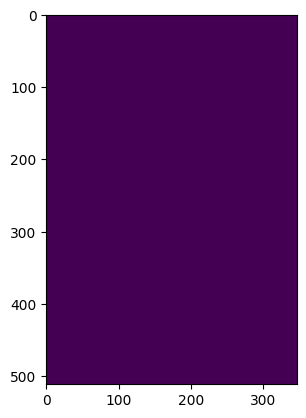

In [11]:
features_path = out_dir.joinpath("features.pkl")

with open(features_path, "rb") as pkl:
    features = pickle.load(pkl)

plt.imshow(features["msa"])
plt.show()

Select result to plot:

In [12]:
result_widget = widgets.Dropdown(options=glob.glob(f"{out_dir}/result*.pkl"), value=None)
display(result_widget)

Dropdown(options=('AF_models/H1142/result_model_5_multimer_v2_pred_4.pkl', 'AF_models/H1142/result_model_5_mul…

Plot the Predicted Aligned Error (PAE):

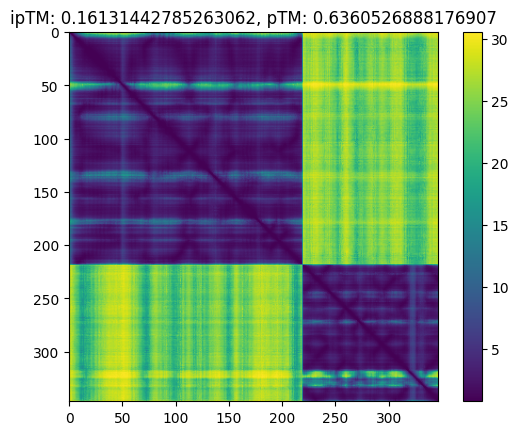

In [13]:
results_path = result_widget.value
with open(results_path, "rb") as pkl:
    results = pickle.load(pkl)

iptm = results["iptm"]
ptm = results["ptm"]
plt.imshow(results["predicted_aligned_error"])
plt.title(f"ipTM: {iptm}, pTM: {ptm}")
plt.colorbar()
plt.show()

Plot approximate distances from predicted distogram:

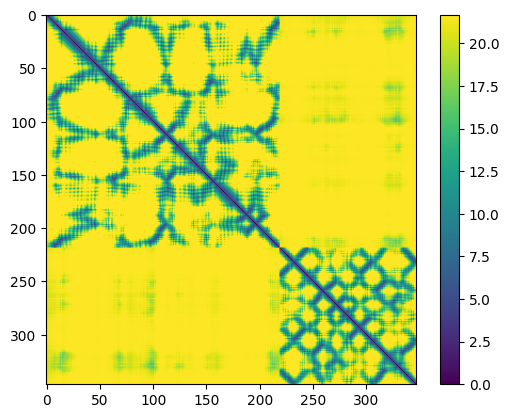

In [14]:

def get_distance_predictions(results, interpolate=True):
    bin_edges = results["distogram"]["bin_edges"]
    bin_edges = np.insert(bin_edges, 0, 0)

    if interpolate:
        distogram_softmax = softmax(results["distogram"]["logits"], axis=2)
        distance_predictions = np.sum(np.multiply(distogram_softmax, bin_edges), axis=2)
    else:  # pick maximum probability distance instead
        distogram_argmax = np.argmax(
            results["distogram"]["logits"][:, :, :63], axis=2
        )  # skips last bin to avoid being too conservative
        distance_predictions = bin_edges[distogram_argmax]

    return distance_predictions

plt.imshow(get_distance_predictions(results))
plt.colorbar()
plt.show()

In [6]:
#@title Compare predictions to the template
import py3Dmol
from colabfold.colabfold import plot_plddt_legend
from colabfold.colabfold import pymol_color_list, alphabet_list

rank_num = 0 #@param ["0", "1", "2", "3", "4", "5"] {type:"raw"}
color = "chain" #@param ["chain", "lDDT", "rainbow"]
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}

def show_pdb(pdb_file, extension, show_sidechains=False, show_mainchains=False, color="lDDT"):
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb_file,'r').read(), extension)

  if color == "lDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    chains = len(target_sequences) + 1
    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})

  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  view.zoomTo()
  return view

prediction_pdb = f"{out_dir}/ranked_{rank_num}.pdb"
template_pdb = f"{mmcif_path}/0000.cif"

print("Template")
show_pdb(template_pdb, "cif", show_sidechains, show_mainchains, color).show()
print("Prediction")
show_pdb(prediction_pdb, "pdb", show_sidechains, show_mainchains, color).show()

NameError: name 'mmcif_path' is not defined